In [1]:
%matplotlib inline
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ニューラルネットワーク
注：事前に[パラメータ最適化](Optimize.ipynb)、[Dataset・DataLoader](Dataset_and_DataLoader.ipynb)を理解してから、本章を学習したほうが良い
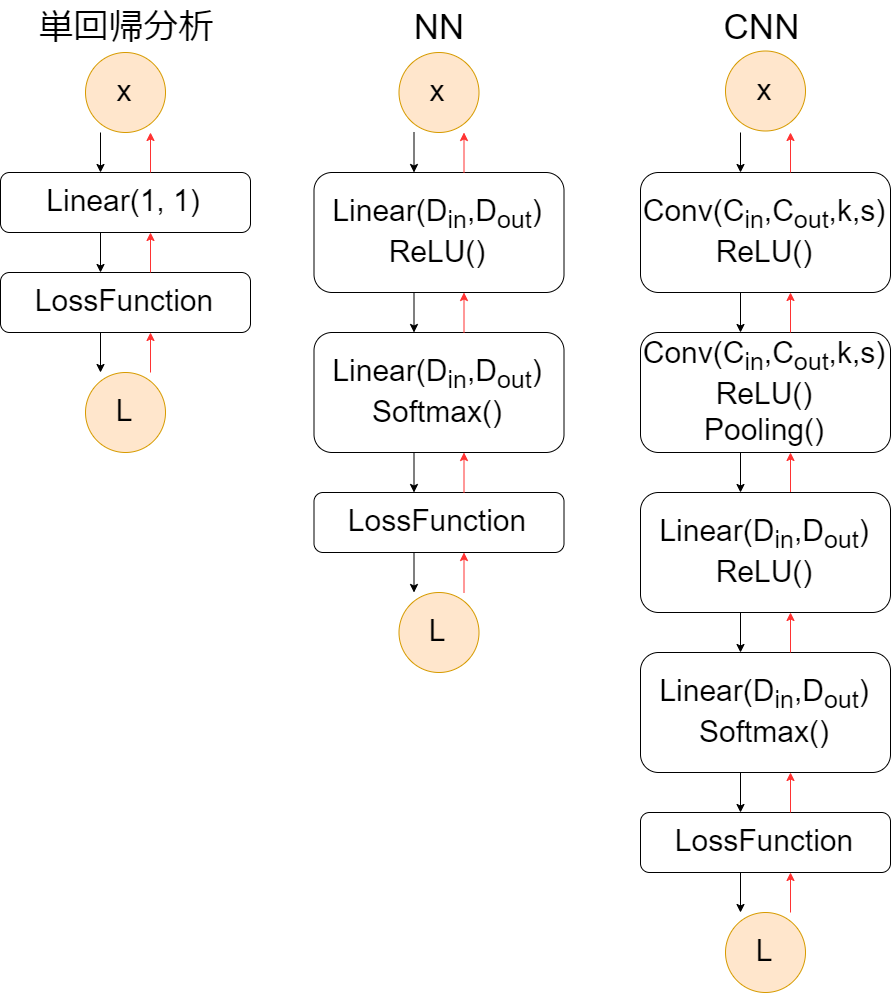

- ReLU :
    - $max(0, x)$と同じ
    - シグモイド関数を活性化関数として使用した場合、DNNでは層が深くなるにつれ勾配が消失する問題が発生するため、ReLUが使われるようになっている
    - その他にも、「計算式がシンプルなので処理が速い」などのメリットがある
- Softmax : <br>
$n$次元の入力Tensorに適応することで、$n$次元の出力Tensorの要素[0, 1]の範囲にクランプし、合計が1になるようにスケーリングする

# ニューラルネットワークモデルの作成
自分でカスタムしたニューラルネットワークモデルを作成する場合は、`__init__`、`forward`の2つは必ず実装する必要がある
- torch.nn
    - `Module` : 現在の状態（ニューラルネットワークの層の重みなど）を保持する機能を持ち、関数のように呼び出すことができる。ネットワークが持つ`Parameter`も管理していて、重みの更新のために勾配の保持や初期化を繰り返し行う。
    - `Parameter` : Tensorのラッパークラスになる。Tensorが`requires_grad`属性を持っている場合、誤差逆伝搬時に`Module`に更新対象であることを知らせる。

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.loss_train_log = []
        self.loss_test_log = []
        
        # 2次元（28x28）の画像を、1次元ベクトルの748ピクセルの値へと変換するレイヤー
        self.flatten = nn.Flatten()
        # nn.Sequential : モジュールを順番に格納する箱のような要素
        self.linear_relu_stack = nn.Sequential(
            # 線形変換
            nn.Linear(in_features = 784, out_features = 200),
            # 非線形な活性化関数：ニューラルネットワークの入力と出力の間にある、複雑な関係性を表現するために重要な要素
            nn.ReLU(),
            nn.Linear(200, 10)
        )
        # 誤差関数の設定
        self.loss = nn.CrossEntropyLoss() 
        # 最適化手法の設定
        self.optimizer = optim.SGD(self.linear_relu_stack.parameters(), lr = 1e-2)
        
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)
    
model = NeuralNetwork()
# モデルの表示
print(model)
# モデルの学習可能なパラメータ
print(len(list(model.parameters())))
print(list(model.parameters())[0].size())

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
  (loss): CrossEntropyLoss()
)
4
torch.Size([200, 784])


## データセットの読み込み

In [3]:
train_data = torchvision.datasets.MNIST(
    root = "../data",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root = "../data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

Image batch shape [batch_size : 64, color : 1, width : 28, height : 28]
Labels batch shape : 64


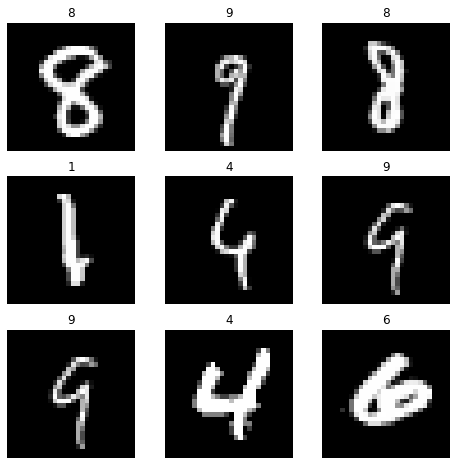

In [4]:
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)
# 辞書型変数にまとめると学習・検証の実施時に扱いやすくなる
dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}
# イテレータに変換
batch_iterator = iter(dataloaders_dict["train"])
# 要素を取り出す
imgs, labels = next(batch_iterator)
print("Image batch shape [batch_size : %d, color : %d, width : %d, height : %d]"
      % (imgs.size()[0], imgs.size()[1], imgs.size()[2], imgs.size()[3]))
print(f"Labels batch shape : {labels.size()[0]}")

# 訓練データの表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 3, 3
for i in range(rows * cols):
    idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
    # データの取得
    img, label = imgs[idx], labels[idx]
    figure.add_subplot(cols, rows, i + 1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap = "gray")
plt.show()

# モデルの学習と評価

epoch : 1
loss_train : 1.246708804356264, acc_train : 0.7532982230186462
loss_test  : 0.5830730998971659, acc_test : 0.8649482727050781
epoch : 10
loss_train : 0.2577278058626441, acc_train : 0.9271388649940491
loss_test  : 0.24394395382730824, acc_test : 0.9307324886322021
epoch : 20
loss_train : 0.18450254305545835, acc_train : 0.9487606883049011
loss_test  : 0.18444348632055482, acc_test : 0.9473527073860168
epoch : 30
loss_train : 0.14281206988473374, acc_train : 0.9600213170051575
loss_test  : 0.14602740042528528, acc_test : 0.9574044346809387
epoch : 40
loss_train : 0.11557156876571524, acc_train : 0.968533456325531
loss_test  : 0.12351735887728679, acc_test : 0.9652667045593262
epoch : 50
loss_train : 0.09630759274249455, acc_train : 0.9741637706756592
loss_test  : 0.10840426644630682, acc_test : 0.96875


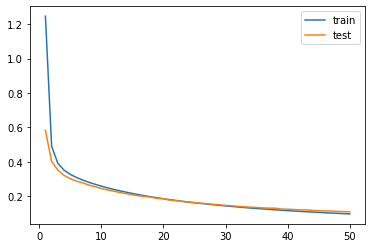

In [5]:
for epoch in range(50): # エポック数分ループを回す
    loss_train = 0.0
    acc_train = 0.0
    loss_test = 0.0
    acc_test = 0.0
    
    # 学習
    for (x, t) in train_dataloader:
        # パラメータの勾配をリセット
        model.optimizer.zero_grad()
        # 順伝搬＋逆伝搬＋パラメータ更新
        y = model(x)
        loss = model.loss(y, t)
        loss.backward()
        model.optimizer.step()
        # 統計情報の記録
        loss_train += loss.item()
        acc_train += sum(y.argmax(axis=1) == t) / len(t)
        
    # 検証
    with torch.no_grad(): # テストでは勾配を求める必要がないので、勾配を求めないように設定
        for x, t in test_dataloader:
            y = model(x)
            loss = model.loss(y, t)
            loss_test += loss.item()
            acc_test += sum(y.argmax(axis=1) == t) / len(t)
            
    # 結果の記録・表示
    model.loss_train_log.append(loss_train / len(train_dataloader))
    model.loss_test_log.append(loss_test / len(test_dataloader))
    if epoch == 0 or epoch % 10 == 9:
        print(f"epoch : {epoch + 1}")
        print(f"loss_train : {loss_train / len(train_dataloader)}, acc_train : {acc_train / len(train_dataloader)}")
        print(f"loss_test  : {loss_test / len(test_dataloader)}, acc_test : {acc_test / len(test_dataloader)}")
        
# Lossのログ表示
plt.plot(range(1, len(model.loss_train_log) + 1), model.loss_train_log, label = "train")
plt.plot(range(1, len(model.loss_test_log) + 1),  model.loss_test_log,  label = "test")
plt.legend(loc = "upper right") # 凡例表示
torch.save(model, "../model/nn_mnist.pth")

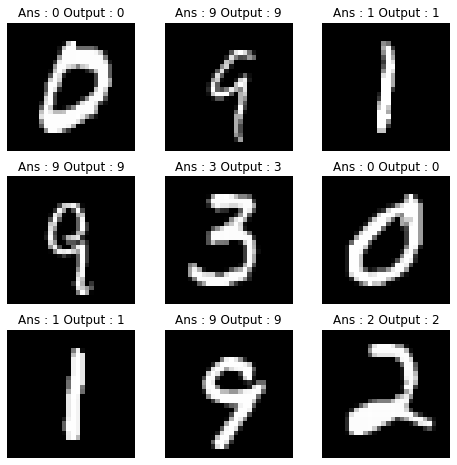

In [6]:
# 推論結果の表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 3, 3
for i in range(rows * cols):
    idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
    # データの取得
    img, label = imgs[idx], labels[idx]
    figure.add_subplot(cols, rows, i + 1)
    plt.title(f"Ans : {label.item()} Output : {model(img).argmax(axis=1).item()}")
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap = "gray")
plt.show()